## About the dataset
The following information are retrieved from [data world](https://data.world/data-society/pima-indians-diabetes-database)

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable (0 or 1)

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

from scipy.stats import skew
from scipy.stats import kurtosis

In [2]:
df = pd.read_csv('../data/diabetes.csv')

In [3]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

### Analyze data:
#### Descriptive statistics

In [4]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


no null value in the data set

In [6]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

there is no null value, but you obviously can't have 0 blood pressure, 0 skinthickness, etc. So some of the missing value here is replaced with 0. To spot them more easily, we will replace those with NaN

In [7]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [8]:
for key in df.columns:
    print("Column {} has {:.2f}% missing value".format(key, (df[key].isnull().sum() / len(df) * 100)))

Column Pregnancies has 0.00% missing value
Column Glucose has 0.65% missing value
Column BloodPressure has 4.56% missing value
Column SkinThickness has 29.56% missing value
Column Insulin has 48.70% missing value
Column BMI has 1.43% missing value
Column DiabetesPedigreeFunction has 0.00% missing value
Column Age has 0.00% missing value
Column Outcome has 0.00% missing value


## Replacing missing value

### Insulin level is different for different Outcome group

In [9]:
def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [10]:
median_target('Insulin')

Outcome  Insulin
0        0    102.5
1        1    169.5

We will therefore replace the missing data with the relevant insulin level depending on the Outcome

In [11]:
df.loc[(df['Outcome'] == 0 ) & (df['Insulin'].isnull()), 'Insulin'] = 102.5
df.loc[(df['Outcome'] == 1 ) & (df['Insulin'].isnull()), 'Insulin'] = 169.5

We will do the same thing for the others

### Glucose

In [12]:
median_target('Glucose')

Outcome  Glucose
0        0    107.0
1        1    140.0

In [15]:
df.loc[(df['Outcome'] == 0 ) & (df['Glucose'].isnull()), 'Glucose'] = 107
df.loc[(df['Outcome'] == 1 ) & (df['Glucose'].isnull()), 'Glucose'] = 140

### SkinThickness

In [16]:
median_target('SkinThickness')

Outcome  SkinThickness
0        0           27.0
1        1           32.0

In [17]:
df.loc[(df['Outcome'] == 0 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 27
df.loc[(df['Outcome'] == 1 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 32

### BloodPressure

In [18]:
median_target('BloodPressure')

Outcome  BloodPressure
0        0           70.0
1        1           74.5

In [19]:
df.loc[(df['Outcome'] == 0 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 70
df.loc[(df['Outcome'] == 1 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

### BMI

In [20]:
median_target('BMI')

Outcome   BMI
0        0  30.1
1        1  34.3

In [21]:
df.loc[(df['Outcome'] == 0 ) & (df['BMI'].isnull()), 'BMI'] = 30.1
df.loc[(df['Outcome'] == 1 ) & (df['BMI'].isnull()), 'BMI'] = 34.3

#### First visual representation

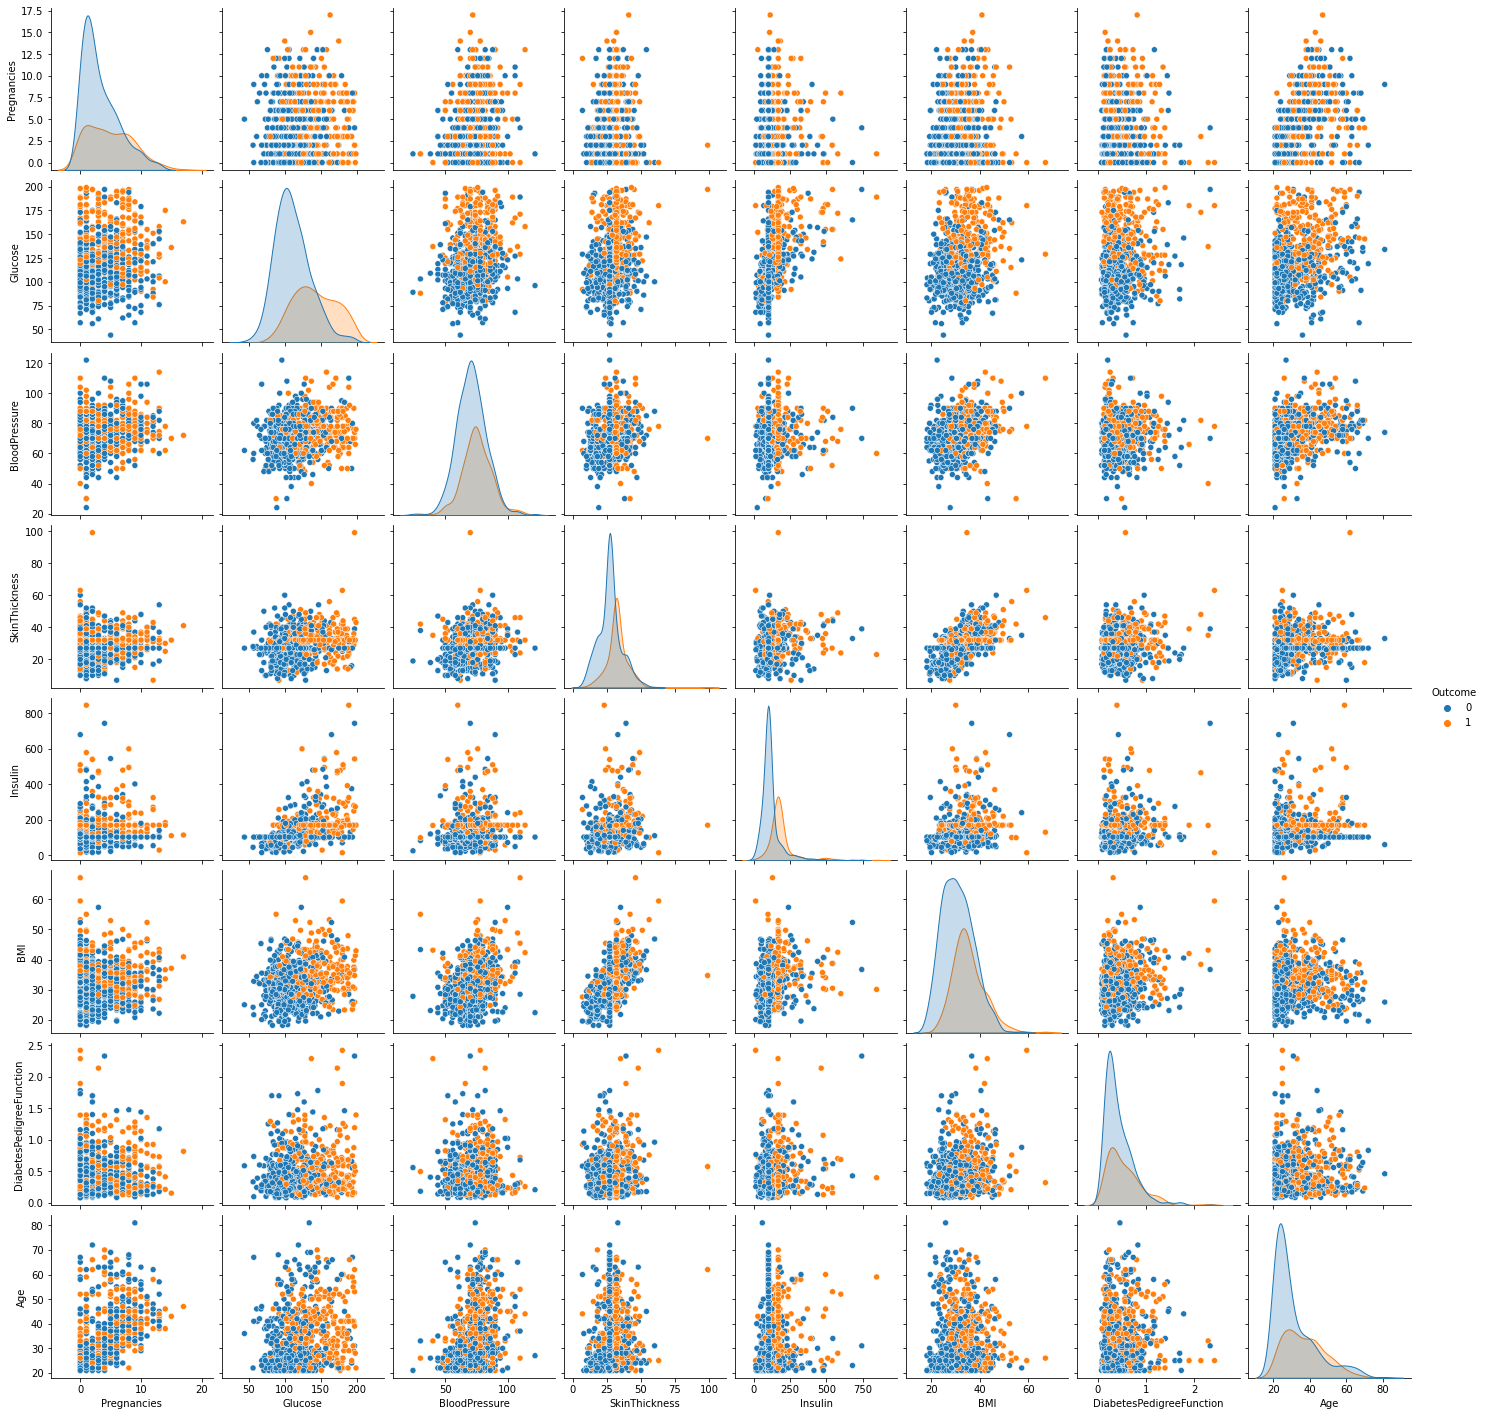

In [22]:
g = sns.pairplot(df, hue='Outcome')

it seems that the data has quite a number of outliers. We will look more into the pregnancy distribution

In [23]:
def plotHist(df, nameOfFeature):
    data = df[nameOfFeature]
    hist_data = np.histogram(data)
    binsize = 0.5
    
    trace1 = go.Histogram(x=data,
                histnorm='density',
                xbins=dict(start=df[nameOfFeature].min()-1,
                          end=df[nameOfFeature].max()+1,
                          size=binsize))
    
    trace_data = [trace1]
    layout = go.Layout(bargroupgap=0.3,
                       title='The distribution of ' + nameOfFeature,
                       xaxis=dict(title=nameOfFeature),
                       yaxis=dict(title='Number of labels'))
    
    fig = go.Figure(data=trace_data, layout=layout)
    py.iplot(fig)

In [24]:
plotHist(df,'Pregnancies')

we have 2 case of someone being pregnant 17 times. If that's not an outlier, I don't know what is.

Next, we will look at Skewness and Kurtosis

Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case

In [34]:
def plotBarCat(df, feature, target):
    """
    This function plot out the histogram of the selected feature
    for each target value
    """
    X_0 = df[df[target]==0][feature]
    X_1 = df[df[target]==1][feature]
    
    trace1 = go.Histogram(x=X_0,
                          opacity=0.75)
    
    trace2 = go.Histogram(x=X_1,
                          opacity=0.75)
    
    data = [trace1, trace2]
    layout = go.Layout(barmode='overlay',
                      title=feature,
                      yaxis=dict(title='Count'))
    fig = go.Figure(data=data, layout=layout)
    
    py.iplot(fig, filename='overlaid histogram')
    
    def SkewKurt(df, target):
        """
        this function print the skewness and the Kurtosis of the data
        """
        print('-*-'*25)
        print("{} mean : ".format(feature), np.mean(df[feature]))
        print("{} var  : ".format(feature), np.var(df[feature]))
        print("{} skew : ".format(feature), skew(df[feature]))
        print("{} kurt : ".format(feature), kurtosis(df[feature]))
        print('-*-'*25)
        
        
    SkewKurt(df,target)

In [35]:
plotBarCat(df,'Pregnancies','Outcome')

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Pregnancies mean :  3.8450520833333335
Pregnancies var  :  11.33927239312061
Pregnancies skew :  0.8999119408414357
Pregnancies kurt :  0.15038273760948462
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [36]:
plotBarCat(df,'Glucose','Outcome')

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Glucose mean :  121.67708333333333
Glucose var  :  926.8566623263908
Glucose skew :  0.5312839835944562
Glucose kurt :  -0.27416524355180094
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [37]:
plotBarCat(df, 'BloodPressure', 'Outcome')

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
BloodPressure mean :  72.38932291666667
BloodPressure var  :  146.36535474989086
BloodPressure skew :  0.14055505233293128
BloodPressure kurt :  1.0705711799888036
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [38]:
plotBarCat(df, 'SkinThickness', 'Outcome')

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
SkinThickness mean :  29.08984375
SkinThickness var  :  78.94375101725261
SkinThickness skew :  0.8158795516469254
SkinThickness kurt :  5.026830910206018
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [39]:
plotBarCat(df, 'Insulin', 'Outcome')

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Insulin mean :  141.75390625
Insulin var  :  7928.623682657878
Insulin skew :  3.0221288568337097
Insulin kurt :  13.755124103150678
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [40]:
plotBarCat(df, 'BMI', 'Outcome')

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
BMI mean :  32.43463541666664
BMI var  :  47.27960767957901
BMI skew :  0.605230559480793
BMI kurt :  0.9017336500645481
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [41]:
plotBarCat(df, 'DiabetesPedigreeFunction', 'Outcome')

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
DiabetesPedigreeFunction mean :  0.4718763020833327
DiabetesPedigreeFunction var  :  0.10963569693840873
DiabetesPedigreeFunction skew :  1.9161592037386292
DiabetesPedigreeFunction kurt :  5.550792047551203
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [42]:
plotBarCat(df, 'Age', 'Outcome')

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Age mean :  33.240885416666664
Age var  :  138.12296379937058
Age skew :  1.127389259531697
Age kurt :  0.6311769413798585
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


### Understand outcome distribution

In [43]:
labels = [str(df['Outcome'].unique()[i]) for i in range (df['Outcome'].nunique())]
values = [df['Outcome'].value_counts()[i] for i in range(df['Outcome'].nunique())]

trace = go.Pie(labels=labels, values=values)
py.iplot([trace])

Our data is unbalanced here. We will need to deal with that

### Investigate outliers

In [33]:
def Outliers(df, feature):
    trace0 = go.Box(y = df[feature],
                   name='All Points',
                    boxpoints='all',
                    jitter=0.3,
                    marker = dict(color = 'rgb(7,40,89)'),
                    line = dict(color = 'rgb(7,40,89)'))
    
    trace1 = go.Box(y=df[feature],
                   name='Only Whiskers',
                    boxpoints = False,
                    jitter=0.3,
                    marker = dict(color = 'rgb(9,56,125)'),
                    line = dict(color = 'rgb(9,56,125)'))
    
    trace2 = go.Box(y=df[feature],
                   name='Suspected Outliers',
                    boxpoints = 'suspectedoutliers',
                    jitter=0.3,
                    marker = dict(
                        color = 'rgb(8,81,156)',
                        outliercolor = 'rgba(219, 64, 82, 0.6)',
                        line = dict(
                            outliercolor = 'rgba(219, 64, 82, 0.6)',
                            outlierwidth = 2)),
                    line = dict(color = 'rgb(8,81,156)'))
    
    trace3 = go.Box(y = df[feature],
                    name = "Whiskers and Outliers",
                    boxpoints = 'outliers',
                    marker = dict(color = 'rgb(107,174,214)'),
                    line = dict(color = 'rgb(107,174,214)'))

    data = [trace0, trace1, trace2, trace3]

    layout = go.Layout(
        title = "{} Outliers".format(feature)
    )

    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig, filename = "Outliers")

In [34]:
Outliers(df,'Pregnancies')

In [35]:
Outliers(df,'Glucose')

In [36]:
Outliers(df,'BloodPressure')

In [37]:
Outliers(df,'SkinThickness')

In [38]:
Outliers(df,'Insulin')

In [39]:
Outliers(df,'BMI')

In [40]:
Outliers(df,'DiabetesPedigreeFunction')

In [41]:
Outliers(df,'Age')

## Remove outliers

In [42]:
def RemoveOutliers(df, feature, drop=False):
    valueOfFeature = df[feature]
    
    Q1 = np.percentile(valueOfFeature, 25)
    Q3 = np.percentile(valueOfFeature, 75)
    
    IQR = (Q3 - Q1) * 1.5
    outliers_index = valueOfFeature[~((valueOfFeature >= Q1 - IQR) & 
                                      (valueOfFeature <= Q3 + IQR))].index.tolist()
    outliers_value = valueOfFeature[~((valueOfFeature >= Q1 - IQR) &
                                      (valueOfFeature <= Q3 + IQR))].values
    
    # Remove the outliers, if any were specified
    print("Number of outliers (inc duplicates): {} and outliers: {}".format(len(outliers_index), outliers_value))
    if drop:
        good_data = df.drop(df.index[outliers_index]).reset_index(drop = True)
        print ("New dataset with removed outliers has {} samples with {} features each.".format(*good_data.shape))
        return good_data
    else: 
        print ("Nothing happens, df.shape = ",df_out.shape)
        return df

In [43]:
df_clean = RemoveOutliers(df, 'Pregnancies', True)
df_clean = RemoveOutliers(df_clean, 'Glucose', True)
df_clean = RemoveOutliers(df_clean, 'BloodPressure', True)
df_clean = RemoveOutliers(df_clean, 'SkinThickness', True)
df_clean = RemoveOutliers(df_clean, 'Insulin', True)
df_clean = RemoveOutliers(df_clean, 'BMI', True)
df_clean = RemoveOutliers(df_clean, 'DiabetesPedigreeFunction', True)
df_clean = RemoveOutliers(df_clean, 'Age', True)


Number of outliers (inc duplicates): 4 and outliers: [15 17 14 14]
New dataset with removed outliers has 764 samples with 9 features each.
Number of outliers (inc duplicates): 0 and outliers: []
New dataset with removed outliers has 764 samples with 9 features each.
Number of outliers (inc duplicates): 14 and outliers: [ 30. 110. 108. 122.  30. 110. 108. 110.  24.  38. 106. 106. 106. 114.]
New dataset with removed outliers has 750 samples with 9 features each.
Number of outliers (inc duplicates): 85 and outliers: [45. 47. 11. 47. 11. 10. 60. 13. 13. 54. 51. 56. 14. 13. 50. 44. 12. 44.
 13. 44. 54. 14.  7. 50. 52. 10. 44. 43. 45. 14. 10. 11. 12. 43. 13. 12.
 48. 43. 43.  8. 13. 14. 12. 49. 46. 46. 11.  8. 12. 63. 12. 45. 13. 48.
 13. 10. 45.  7. 52. 49. 43. 14. 47. 99. 46. 11. 50. 45. 14. 13. 13. 47.
 12. 48. 43. 46. 45. 10. 46. 49. 11. 13. 46. 44. 48.]
New dataset with removed outliers has 665 samples with 9 features each.
Number of outliers (inc duplicates): 41 and outliers: [846. 300

In [44]:
print('Original df shape: {}, new df shape: {}. We lost {} rows, which is {:.2f}% of our data'.format(df.shape[0], 
                                                                                                  df_clean.shape[0],
                                                                                                  df.shape[0] - df_clean.shape[0],
                                                                                                  (df.shape[0]-df_clean.shape[0])/df.shape[0]*100))

Original df shape: 768, new df shape: 582. We lost 186 rows, which is 24.22% of our data


## Algo selection: Baseline

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [46]:
y = df_clean['Outcome']
X = df_clean.loc[:, df_clean.columns != 'Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                   random_state=42,
                                                   stratify=df_clean['Outcome'])

In [47]:
def GetBasedModel():
    basedModels = []
    basedModels.append(('XGB'  , XGBClassifier()))
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))
    

    
    return basedModels

In [48]:
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [49]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)

[16:47:50] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:51] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:51] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:51] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [50]:
def ScoreDataFrame(names,results):
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

In [51]:
basedLineScore = ScoreDataFrame(names,results)
basedLineScore

Model   Score
0    XGB  0.9039
1     LR  0.8533
2    LDA  0.8534
3    KNN  0.8877
4   CART  0.8510
5     NB  0.8511
6    SVM  0.8718
7     AB  0.8899
8    GBM  0.9014
9     RF  0.8924
10    ET  0.8946

## Feature Selection
We will try to select only a few top feature here to see whether the overall performance increase

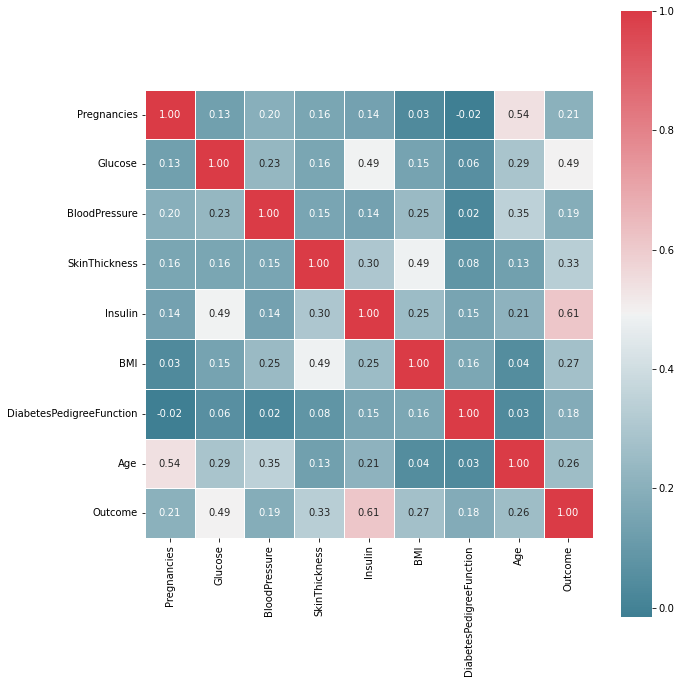

In [52]:
def HeatMap(df):
    correlations = df.corr()
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    fig, ax = plt.subplots(figsize=(10, 10))
    fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, fmt='.2f', square=True,
                     linewidths=.5, annot=True)
    fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 10)
    fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.tight_layout()
    plt.show()
    
HeatMap(df_clean)

There is no highly correlated feature in this dataset

### Feature importance

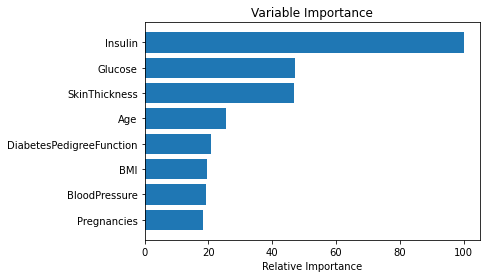

In [53]:
clf = ExtraTreesClassifier(n_estimators=300,
                              random_state=42)
clf.fit(X_train, y_train)

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [54]:
df_important_feature = df_clean[['Insulin', 'Glucose', 'SkinThickness', 'Age', 'DiabetesPedigreeFunction', 'BMI', 'Outcome']]

In [55]:
name_feature_imp = df_important_feature.columns

In [56]:
y_selected = df_important_feature['Outcome']
X_selected = df_important_feature.loc[:, df_important_feature.columns != 'Outcome']

X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df_important_feature['Outcome'])

names,results = BasedLine2(X_train_selected, y_train_selected, models)

[16:48:42] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:42] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:42] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:42] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [57]:
featureSelectedScore = ScoreDataFrame(names, results)
comparedModels = pd.concat([basedLineScore,
                             featureSelectedScore,
                            ], axis=1)
comparedModels

Model   Score Model   Score
0    XGB  0.9039   XGB  0.8905
1     LR  0.8533    LR  0.8494
2    LDA  0.8534   LDA  0.8496
3    KNN  0.8877   KNN  0.8712
4   CART  0.8510  CART  0.8646
5     NB  0.8511    NB  0.8645
6    SVM  0.8718   SVM  0.8648
7     AB  0.8899    AB  0.8797
8    GBM  0.9014   GBM  0.8819
9     RF  0.8924    RF  0.8883
10    ET  0.8946    ET  0.8967

Overall selecting the feature even further seems to decrease performance, therefore we will keep all the features instead

### Data Scaling

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


def GetScaledModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()

    pipelines = []
    pipelines.append((nameOfScaler+'XGB'  , Pipeline([('Scaler', scaler),('XGB'  , XGBClassifier())])))
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression())])))
    pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))


    return pipelines

In [59]:
models = GetScaledModel('minmax')


names,results = BasedLine2(X_train, y_train,models)

scaledFeatureSelected = ScoreDataFrame(names, results)
comparedModels = pd.concat([basedLineScore,
                             featureSelectedScore,
                            scaledFeatureSelected
                            ], axis=1)
comparedModels

[16:49:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Model   Score Model   Score       Model   Score
0    XGB  0.9039   XGB  0.8905   minmaxXGB  0.9061
1     LR  0.8533    LR  0.8494    minmaxLR  0.8465
2    LDA  0.8534   LDA  0.8496   minmaxLDA  0.8534
3    KNN  0.8877   KNN  0.8712   minmaxKNN  0.8557
4   CART  0.8510  CART  0.8646  minmaxCART  0.8555
5     NB  0.8511    NB  0.8645    minmaxNB  0.8511
6    SVM  0.8718   SVM  0.8648   minmaxSVM  0.8831
7     AB  0.8899    AB  0.8797    minmaxAB  0.8899
8    GBM  0.9014   GBM  0.8819   minmaxGBM  0.9015
9     RF  0.8924    RF  0.8883    minmaxRF  0.8922
10    ET  0.8946    ET  0.8967    minmaxET  0.8991

In [60]:
models = GetScaledModel('standard')


names,results = BasedLine2(X_train, y_train,models)

standardFeatureSelected = ScoreDataFrame(names, results)
comparedModels = pd.concat([basedLineScore,
                             featureSelectedScore,
                            scaledFeatureSelected,
                            standardFeatureSelected
                            ], axis=1)
comparedModels

[16:49:18] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:18] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:18] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:18] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Model   Score Model   Score       Model   Score         Model   Score
0    XGB  0.9039   XGB  0.8905   minmaxXGB  0.9061   standardXGB  0.9039
1     LR  0.8533    LR  0.8494    minmaxLR  0.8465    standardLR  0.8557
2    LDA  0.8534   LDA  0.8496   minmaxLDA  0.8534   standardLDA  0.8534
3    KNN  0.8877   KNN  0.8712   minmaxKNN  0.8557   standardKNN  0.8763
4   CART  0.8510  CART  0.8646  minmaxCART  0.8555  standardCART  0.8578
5     NB  0.8511    NB  0.8645    minmaxNB  0.8511    standardNB  0.8511
6    SVM  0.8718   SVM  0.8648   minmaxSVM  0.8831   standardSVM  0.8717
7     AB  0.8899    AB  0.8797    minmaxAB  0.8899    standardAB  0.8899
8    GBM  0.9014   GBM  0.8819   minmaxGBM  0.9015   standardGBM  0.8992
9     RF  0.8924    RF  0.8883    minmaxRF  0.8922    standardRF  0.8969
10    ET  0.8946    ET  0.8967    minmaxET  0.8991    standardET  0.8923

No real improvement gained here

## Algorithm tuning

In [61]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

In [62]:
class SearchParams(object):
    def __init__(self, X_train, y_train, model, hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
    
    def Kfold(self):
        return StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
    def RandomSearch(self):
        cv = self.Kfold()
        clf = RandomizedSearchCV(self.model,
                                self.hyperparameters,
                                random_state=42,
                                n_iter=100,
                                cv=cv,
                                verbose=0,
                                n_jobs=-1)
        
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        
        print("best: %f using %s" % (message))
        
        return best_model, best_model.best_params_
    
    def GridSearch(self):
        cv = self.Kfold()
        clf = GridSearchCV(self.model,
                          self.hyperparameters,
                          cv=cv,
                          verbose=0,
                          n_jobs=-1)
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        
        print("best score: %f using %s" % (message))
        
        return best_model, best_model.best_params_
        
    
    def BestModelPredict(self, X_test, random=False):
        if random:
            best_model, _ = self.RandomSearch()
            pred = best_model.predict(X_test)
        else:
            best_model, _ = self.GridSearch()
            pred = best_model.predict(X_test)
        return pred
            

### Logistic Regression

In [63]:
model_lr = LogisticRegression()

# define regularization
reg_type = ['l1', 'l2', 'elasticnet']


param_lr = dict(penalty=reg_type)

In [64]:
LR_Search = SearchParams(X_train, y_train, model_lr, param_lr)
Prediction_Random_LR = LR_Search.BestModelPredict(X_test, random=False)

best score: 0.848589 using {'penalty': 'l2'}


The result is abit less good here. We will keep the original model for simplicity

### KNN

In [65]:
model_KNN = KNeighborsClassifier()

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_knn = dict(n_neighbors=neighbors)

In [66]:
KNN_Search = SearchParams(X_train, y_train, model_KNN, param_knn)
Prediction_KNN = KNN_Search.BestModelPredict(X_test, random=False)

best score: 0.896839 using {'n_neighbors': 10}


Slight increase of 1% here as well compare to previous model

### SVC

In [67]:
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = [ 'linear' , 'poly' , 'rbf' , 'sigmoid' ]
param_grid = dict(C=c_values, kernel=kernel_values)
model_SVC = SVC()

In [68]:
SVC_Search = SearchParams(X_train, y_train, model_SVC, param_grid)
Prediction_SVC = SVC_Search.BestModelPredict(X_test, random=True)

best: 0.887618 using {'kernel': 'poly', 'C': 0.3}


Some improvement in performance is gained here

### Decision Tree

In [69]:
max_depth_value = [1, 2, 3, None]
max_features_value =  [1, 2, 3, 4, 5, None]
min_samples_leaf_value = [1, 2, 3, 4, 5, None]
criterion_value = ["gini", "entropy"]

In [70]:
param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value)
model_CART = DecisionTreeClassifier()

In [71]:
CART_Search = SearchParams(X_train, y_train, model_CART, param_grid)
Prediction_CART = CART_Search.BestModelPredict(X_test, random=True)

best: 0.876280 using {'min_samples_leaf': 2, 'max_features': 4, 'max_depth': 2, 'criterion': 'gini'}


Some improvement here, of more than 2%

### AdaBoost

In [72]:
learning_rate_value = [.01, .05, .1, .5, 1]
n_estimators_value = [50, 100, 150, 200, 250, 300]

param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

In [73]:
model_Ad = AdaBoostClassifier()
Ad_Search = SearchParams(X_train, y_train, model_Ad, param_grid)
Prediction_Ad = Ad_Search.BestModelPredict(X_test)

best score: 0.903762 using {'learning_rate': 1, 'n_estimators': 50}


Some minor imprvement here as well

### GradientBoosting

In [74]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300]

param_grid = dict(learning_rate=learning_rate_value, 
                  n_estimators=n_estimators_value)

In [75]:
model_GB = GradientBoostingClassifier()
GB_Search = SearchParams(X_train, y_train, model_GB, param_grid)
Prediction_GB = GB_Search.BestModelPredict(X_test)

best score: 0.903736 using {'learning_rate': 0.01, 'n_estimators': 150}


Basically the same. we will keep the default model for simplicity

## Ensemble method

We will drop some of the weakest learner out, and only select a few with the best prediction

In [79]:
from sklearn.ensemble import VotingClassifier

In [76]:
model0 = XGBClassifier()

model1 = LogisticRegression()

param = {'n_neighbors': 10}
model2 = KNeighborsClassifier(**param)

param = {'kernel': 'poly', 'C': 0.3}
model3 = SVC(**param)

param = {'min_samples_leaf': 2, 'max_features': 4, 'max_depth': 2, 'criterion': 'gini'}
model4 = DecisionTreeClassifier(**param)

param = {'learning_rate': 1, 'n_estimators': 50}
model5 = AdaBoostClassifier(**param)

model6 = GradientBoostingClassifier()

model7 = GaussianNB()

model8 = RandomForestClassifier()

model9 = ExtraTreesClassifier()


In [77]:
estimators = [("XGB", model0), ('LR',model1), ('KNN',model2), 
              ('SVC',model3), ('ADa',model5), ('GB',model6), 
              ('NB',model7), ('RF',model8),  ('ET',model9)]

In [80]:
kfold = StratifiedKFold(n_splits=5)

ensemble = VotingClassifier(estimators)
results = cross_val_score(ensemble, X_train, y_train, cv=kfold)
print('Accuracy on train: ',results.mean())

ensemble_model = ensemble.fit(X_train, y_train)
pred = ensemble_model.predict(X_test)
print('Accuracy on test:' , (y_test == pred).mean())

[16:57:29] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:30] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:31] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:31] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Surprisingly, the overall accuracy of the ensemble seems to underperform comparing to XGBoost

In [81]:
XGB = XGBClassifier()
results = cross_val_score(XGB, X_train, y_train, cv=kfold)
print('Accuracy on train: ',results.mean())

xgb_model = XGB.fit(X_train, y_train)
pred_xgb = xgb_model.predict(X_test)
print('Accuracy on test:' , (y_test == pred_xgb).mean())

[16:58:12] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:12] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:12] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:12] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

On test, the accuracy of XGBoost is actually at 91%!! We will jsut use XGB as a classifier

In [86]:
# export the clean df
df_clean.to_csv('cleaned_df.csv', index=False)